___________________________
# Medical Image Segmentation
## [Unet](https://arxiv.org/abs/1505.04597): Convolutional  Networks for Biomedical Image Segmentation

### Implemetation using Tensorflow Slim Framework
____________________________________

## 1. Network Architecture.


<img src='Unet.png'>

**The basic encoder block has:**

> 1. 2 convolution layer: 3x3 kernel with output channels doubling every block repeat.
> 2. Relu activation.
> 3. Max pool layer 2x2.

**The basic decoder block has:**
> 1. Up convolve 2x2,  
> 2. Concatinate with the corresponding encoder output.
> 3. convolution layer: 3x3 kernel with output channels halfs every block repeat.
> 4. Relu activation

The final output is a 1x1 convolution outputing a binary mask `[0 or 1]`. 

**Other aspects from the paper:**
> 1. Since very little training data is available, we need to use excessive data augmention by applying elastic deformations to the available training images.
> 2. They apply a softmax cross-entropy weighted loss, to obtain a classification between two binary classes `[0,1]`. 

## 2. Segmentation of White blood cells (WBC) to evaluate U-net architecture

> The WBC datasets are available in segmentaion_train_data, segmentation_validation_data and segmentaion_test

In [2]:
# load the necessary
import matplotlib.pylab as plt
%matplotlib inline
import os
import numpy as np
import math as m
import sys
print('Python version:',sys.version)
import tensorflow as tf
print('TF version:',tf.__version__)

Python version: 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
TF version: 1.8.0


____________________________________
### Checking the train data

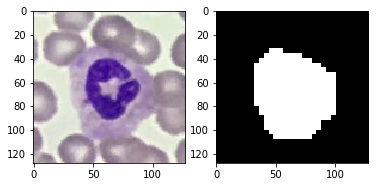

In [3]:

TRAIN_DATA_PATH = 'segmentation_train_data'
train_img = plt.imread(os.path.join(TRAIN_DATA_PATH,'train-0.jpg' ))
train_mask = plt.imread(os.path.join(TRAIN_DATA_PATH,'train-0-mask.jpg' ))

plt.subplot(1,2,1)
plt.imshow(train_img)
plt.subplot(1,2,2)
plt.imshow(train_mask, cmap='gray')


In [4]:
# the input labels
print('Mask Shape:',train_mask.shape)
print('Mask Values:',np.unique(train_mask))

Mask Shape: (128, 128)
Mask Values: [  0   1   2 253 254 255]


The mask is a single channel, but its not a binary mask. Need to be threshold to make it binary.

__________________________--
### Checking the validation data

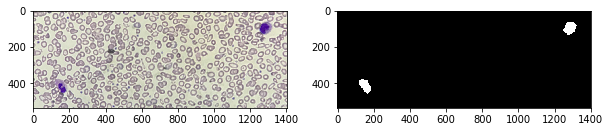

In [5]:
VALID_DATA_PATH = 'segmentation_validation_data'
valid_img = plt.imread(os.path.join(VALID_DATA_PATH,'017532875DDF.jpg' ))
valid_mask = plt.imread(os.path.join(VALID_DATA_PATH,'017532875DDF-vmask.jpg' ))
plt.figure(figsize=(10,12))
plt.subplot(1,2,1)
plt.imshow(valid_img)
plt.subplot(1,2,2)
plt.imshow(valid_mask, cmap='gray')

In [6]:
# the validation labels
print('Mask Shape:',valid_img.shape)
print('Mask Values:',np.unique(valid_mask, return_counts=True))

Mask Shape: (537, 1402, 3)
Mask Values: (array([  0,   1,   2,   3,   4,   5,   6, 250, 251, 252, 253, 254, 255],
      dtype=uint8), array([745157,    292,    201,     66,     38,     13,      3,      7,
           23,     61,    169,    297,   6547]))


> The validation image sizes are different, and so the model we choose needs to be a fully convolutional network (with no dense layer) to handle different input size, even though the input is fixed to 128x128.

__________________________________________
## 3. Preparing the inputs

Data augmentation in tensorflow:
>   1. Random cropping - Randomly crop a portion of the image and resize.  
>   2. Random flips - flip the images randomly
>   3. Rotation at different angles  
>   4. All the above done randomly at each batch  

In [7]:
# The data augmentation function 
# Create a 'train.csv' file that contains images and mask as columns

INPUT_WIDTH = 128
INPUT_HEIGHT = 128

def _crop_random(image, mask):
    """Randomly crops image and mask"""
    seed = np.random.randint(42)
    
    cond_crop = tf.cast(tf.random_uniform(
        [], maxval=2, dtype=tf.int32, seed=seed), tf.bool)
    
    image = tf.cond(cond_crop, lambda: tf.image.resize_images(
        tf.random_crop(image, [int(INPUT_HEIGHT * 0.75), int(INPUT_WIDTH * 0.75), 3], seed=seed),
        size=[INPUT_HEIGHT, INPUT_WIDTH]), lambda: tf.cast(image, tf.float32))
    mask = tf.cond(cond_crop, lambda: tf.image.resize_images(
        tf.random_crop(mask, [int(INPUT_HEIGHT * 0.75), int(INPUT_WIDTH * 0.75), 1], seed=seed), 
        size=[INPUT_HEIGHT, INPUT_WIDTH]),lambda: tf.cast(mask, tf.float32))
    
    return image, mask

def _flip_random(image, mask):
    """Randomly flips image left and right"""
    
    seed = np.random.randint(42)
    image = tf.image.random_flip_left_right(image, seed=seed)
    mask = tf.image.random_flip_left_right(mask, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    mask = tf.image.random_flip_up_down(mask, seed=seed)

    return image, mask

def _rotate_random(image, mask):
    """Randomly rotate the image"""
    
    cond_rotate = tf.cast(tf.random_uniform(
        [], maxval=2, dtype=tf.int32), tf.bool)

    div = tf.random_uniform([], minval=1,maxval=5, dtype=tf.int32)
    radian = tf.constant(m.pi) / tf.cast(div, tf.float32)

    image = tf.cond(cond_rotate,lambda:tf.cast(tf.contrib.image.rotate(image, radian), tf.float32),
                    lambda: tf.cast(image, tf.float32))
    mask = tf.cond(cond_rotate,lambda:tf.cast(tf.contrib.image.rotate(mask, radian), tf.float32),
                    lambda: tf.cast(mask, tf.float32))                   

    return image, mask

def _normalize_data(image, mask):
    """Normalize image and mask within range 0-1."""
    image = image / 255.0
    mask = mask / 255.0

    return image, mask

def data_augmentation(image, mask):
    """Function that does random crop, flip, rotate"""
    image, mask = _crop_random(image, mask)
    image, mask = _flip_random(image, mask)
    image, mask = _rotate_random(image, mask)
    image, mask = _normalize_data(image, mask)
                   
    return image, mask
    
def _parse_function(line):
    """Function that parses the input file and decodes the raw jpeg"""
    image_raw, mask_raw = tf.decode_csv(line, record_defaults=[[""],[""]])
    image = tf.image.decode_jpeg(tf.read_file(image_raw))
    mask = tf.image.decode_jpeg(tf.read_file(mask_raw))
    image, mask = data_augmentation(image, mask)
    return image, mask

# The train.txt file must contain the path for images and the labels
filename =['train.csv']
dataset = tf.data.TextLineDataset(filename)
dataset = dataset.map(_parse_function)
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(1)
iterator = dataset.make_one_shot_iterator()

# Run the above
with tf.Session() as sess:
    batch_images_1, batch_labels_1 = sess.run(iterator.get_next())
    batch_images_2, batch_labels_2 = sess.run(iterator.get_next())

______________________________________________
## Few examples of the augmentation pipeline

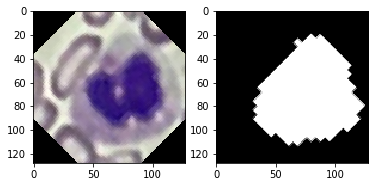

In [8]:
plt.subplot(1,2,1)
plt.imshow(np.squeeze(batch_images_1))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(batch_labels_1), cmap='gray')

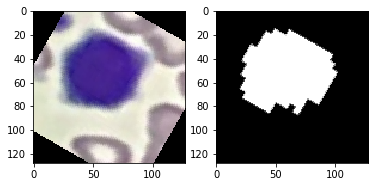

In [9]:
plt.subplot(1,2,1)
plt.imshow(np.squeeze(batch_images_2))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(batch_labels_2), cmap='gray')

----- EOF -----